
# Introducción

La tarea principal es __ayudar a optimizar los gastos de marketing de la compañía Y.Afisha__.

Se proporcionan tres archivos con datos sobre: visitas a la web, pedidos y gastos de marketing. Se solicita información sobre: 
- Cómo los clientes usan el servicio
- Cuándo empiezan a comprar
- Cuánto dinero aporta cada cliente a la compañía
- Cuándo los ingresos cubren el costo de adquisición de clientes

# Descripción de datos

Se trabajará con tres datasets proporcionados por la empresa:

`visits_log_us.csv` Contiene los siguientes datos:
- Uid: identificador único del usuario
- Device: dispositivo del usuario
- Start Ts: fecha y hora de inicio de la sesión
- End Ts: fecha y hora de término de la sesión
- Source Id: identificador de la fuente de anuncios de la que proviene el usuario

Todas las fechas de esta tabla están en formato AAAA-MM-DD.

`orders_log_us.csv` Contiene los siguientes datos:
- Uid: identificador único del usuario que realiza un pedido
- Buy Ts: fecha y hora del pedido
- Revenue: ingresos de Y.Afisha de este pedido.

`costs_us.csv` Contiene los siguientes datos:
- source_id: identificador de la fuente de anuncios
- dt: fecha
- costs: gastos en esta fuente de anuncios en este día

# Pauta de trabajo

Para lograr los objetivos se responderán las siguientes preguntas sobre:

__Visitas__
- ¿Cuántas personas lo usan cada día, semana y mes?
- ¿Cuántas sesiones hay por día?
- ¿Cuál es la duración de cada sesión?
- ¿Con qué frecuencia los usuarios y las usuarias regresan?

__Ventas__
- ¿Cuándo la gente empieza a comprar? (Se revisarán los rangos de tiempo de los datos para seleccionar el intervalo adecuado).
- ¿Cuántos pedidos hacen durante un período de tiempo dado?
- ¿Cuál es el tamaño promedio de compra?
- ¿Cuánto dinero traen? (LTV)

__Marketing__
- ¿Cuánto dinero se gastó? (Total/por fuente de adquisición/a lo largo del tiempo)
- ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?
- ¿Cuán rentables eran las inversiones? (ROMI)

Se trazarán gráficos para mostrar cómo difieren estas métricas para varios dispositivos y fuentes de anuncios y cómo cambian con el tiempo.

Este informe estará dividido en tres partes:
- Preanálisis: Etapa en la cual se cargan los datos y se optimizan en caso de ser necesario, se trabajan los valores duplicados y ausentes, y finalmente, se modifican los datos para facilitar el posterior análisis.
- Análisis: Etapa en la cual se responden las preguntas establecidas y se trazan los gráficos correspondientes.
- Conclusiones: Etapa en la cual se resume la totalidad del informe y se destacan los hallazgos mas importantes del análisis.

## Pre-análisis de los datos

Esta fase contempla todos los preparativos, importación de librerías, limpieza, etc. que se deben realizar antes de empezar con el análisis.

### Importación de librerías

Se procede a importar las librerías necesarias para realizar para el análisis y las visualizaciones correspondientes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st 
import math as mt

Se importan todas las librerias que pudiesen ser necesarias para analizar los datos y crear gráficas.

### Carga y optimización de datos

Ahora, se montarán los dataset usando `read.csv` y se optimizará su uso de espacio corrigiendo el tipo de datos al momento de la importación.

#### Visits

Se cargará una muestra de 500 filas de la tabla, con el fin de descubrir el tipo de datos que tiene y poder optimizarla y trabajar de manera más fluída.

In [4]:
visits_ = pd.read_csv('/datasets/visits_log_us.csv', nrows=500)
visits_.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Device     500 non-null    object
 1   End Ts     500 non-null    object
 2   Source Id  500 non-null    int64 
 3   Start Ts   500 non-null    object
 4   Uid        500 non-null    uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 113.1 KB


Se descubre que hay tres columnas que pueden ser optimizadas, se comenzará por `Device` y después se trabajarán las que contienen fechas. Mediante un `.value_counts()` se averiguará si la columna `Device` es un tipo de dato `'category'`.

In [5]:
visits_['Device'].value_counts()

desktop    363
touch      137
Name: Device, dtype: int64

Efectivamente se le puede considerar una columna de tipo categórico. Se procede a importar el dataset corrigiendo el tipo de dato de `Device` y el de `Start Ts` y `End Ts`.

In [6]:
visits = pd.read_csv(
    '/datasets/visits_log_us.csv',
    dtype={'Device' : 'category'},
    parse_dates=['Start Ts', 'End Ts']
)

Una vez hecha la corrección se revisa el peso total del dataset.

In [7]:
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


Obtenemos un dataset de 11.3 MB que tiene 359.400 filas, es un peso manejable para un dataset tan grande, el proceso de optimización es exitoso. Además, no se observan valores ausentes.

#### Orders

Se cargará una muestra de 500 filas de la tabla, con el fin de descubrir el tipo de datos que tiene y poder optimizarla y trabajar de manera más fluída.

In [8]:
orders_ = pd.read_csv('/datasets/orders_log_us.csv', nrows=500)
orders_.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   500 non-null    object 
 1   Revenue  500 non-null    float64
 2   Uid      500 non-null    uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 45.0 KB


Se descubre que la columna `Buy Ts` está en formato `object` siendo una fecha, por lo que se corregirá.

In [9]:
orders = pd.read_csv(
    '/datasets/orders_log_us.csv',
    parse_dates=['Buy Ts']
)
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


Se importa el dataset optimizado. No se observan valores ausentes.

#### Costs

Se cargará una muestra de 500 filas de la tabla, con el fin de descubrir el tipo de datos que tiene y poder optimizarla y trabajar de manera más fluída.

In [10]:
costs_ = pd.read_csv('/datasets/costs_us.csv', nrows=500)
costs_.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  500 non-null    int64  
 1   dt         500 non-null    object 
 2   costs      500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 40.7 KB


Se descubre que la columna `dt` está en formato `object` siendo una fecha, por lo que se corregirá.

In [11]:
costs = pd.read_csv(
    '/datasets/costs_us.csv',
    parse_dates=['dt']
)
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Se importa el dataset optimizado y no se encuentran valores ausentes.

### Previsualización de datos

Se le dará una revisión a cada uno de los datasets para determinar que esten listos para el análisis.

In [12]:
visits.sample(5)

,Device,End Ts,Source Id,Start Ts,Uid
166562,desktop,2018-03-19 11:30:00,3,2018-03-19 11:27:00,5159464479071029151
66153,touch,2018-02-28 19:59:00,4,2018-02-28 19:57:00,4310904898428673460
270096,desktop,2018-01-27 11:56:00,2,2018-01-27 11:54:00,7046737606684150807
95912,desktop,2017-08-18 15:15:00,1,2017-08-18 14:36:00,17364531836617675008
149272,desktop,2017-12-18 13:21:00,5,2017-12-18 13:21:00,5899480261995766679


Se encuentra que los títulos de las columnas no están en snake case, lo cual podría ralentizar el análisis, por lo que serán cambiados posteriormente para coincidir con snake case. Se revisará el siguiente dataset.

In [13]:
orders.sample(5)

,Buy Ts,Revenue,Uid
3114,2017-07-12 10:42:00,4.89,1048217282460711685
21288,2017-12-01 11:33:00,2.08,7046737606684150807
10319,2017-10-03 13:25:00,6.11,5139615590553126732
27156,2017-12-30 13:02:00,6.11,15243332236720556861
28875,2018-01-10 23:45:00,3.05,5029574109183400594


Sucede lo mismo que con el dataset anterior, este dataset también será corregido. Se revisará el último datastet.

In [14]:
costs.sample(5)

,source_id,dt,costs
2397,10,2018-01-05,7.29
1998,9,2017-11-30,24.51
2227,10,2017-07-19,15.69
803,3,2017-08-17,302.19
1526,5,2017-08-14,82.15


En este dataset los títulos ya se encuentran en snake case por lo cual no se harán cambios.

### Corrección de datos

Esta es la última fase antes del análisis, aquí se harán los cambios mencionados anteriormente y se buscarán y eliminarán los duplicados (en caso de ser necesario). Se comienza con el dataset `visits`.

In [15]:
visits.columns = [col.replace(' ', '_') for col in visits.columns]
visits.columns = visits.columns.str.lower()
print(visits.duplicated().sum())
visits.head(5)

0


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Se reemplazan los espacios en los títulos con `'_'`, para respetar el snake case, se cambian los títulos a minúsculas para que sea más fácil operar con ellos y se descarta la existencia de duplicados. El procedimiento es el mismo para el siguiente dataset.

In [16]:
orders.columns = [col.replace(' ', '_') for col in orders.columns]
orders.columns = orders.columns.str.lower()
print(orders.duplicated().sum())
orders.head(5)

0


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Ahora, se buscarán compras cuyo `revenue` sea igual a 0, si estos valores existen y la cantidad no es significativa, se eliminarán del dataset, si es una cantidad significativa se deberá averiguar la razón detrás del suceso.

In [17]:
orders[orders['revenue'] == 0].count()

buy_ts     51
revenue    51
uid        51
dtype: int64

Se encuentran 51 valores 0 en `revenue` por lo que serán eliminados.

In [18]:
orders = orders[orders['revenue'] != 0]

Ahora todo está listo para pasar al análisis.

## Análisis de los datos

En esta etapa se llevará a cabo el análisis de los datos y, mediante cálculos y visualizaciones, se tratará de responder las preguntas planteadas en el inicio de este informe.

### Visitas

La primera sección del análisis tratará sobre todo lo relacionado a las visitas del sitio web de la compañía.

#### ¿Cuántas personas lo usan cada día, semana y mes?

Para responder esta pregunta se trazarán las métricas: MAU, DAU y WAU además de una serie de gráficos para observar cómo fluctúan los números de visitas a lo largo del periodo estudiado.

In [19]:
visits['session_year'] =  visits['start_ts'].dt.year #Se crean columnas por año, mes, semana y día
visits['session_month'] =  visits['start_ts'].dt.month
visits['session_week'] =  visits['start_ts'].dt.week
visits['session_day'] =  visits['start_ts'].dt.day

mau_total = (visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()) #Aquí se calcula el promedio de usuarios mensuales, para semanas y días se realiza de la misma forma
wau_total = (visits.groupby(['session_month', 'session_week']).agg({'uid': 'nunique'}).mean())
dau_total = (visits.groupby(['session_month', 'session_day']).agg({'uid': 'nunique'}).mean())

print('MAU:', int(mau_total))
print('WAU:' ,int(wau_total))
print('DAU:' ,int(dau_total))

MAU: 23228
WAU: 4911
DAU: 907


Siguiendo las métricas obtenidas: MAU, WAU y DAU, se puede saber que:
- La cantidad de usuarios activos por mes es de: 23.228
- La cantidad de usuarios activos por semana es de: 4.911
- La cantidad de usuarios activos por día es de: 907

Ahora se procederá a la construcción de las visualizaciones, comenzando por el gráfico mensual de visitas.

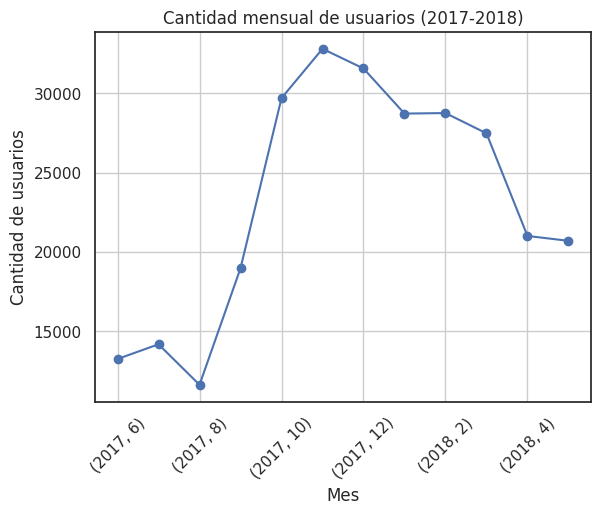

In [20]:
monthly_nusers = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})
sns.set(style='white')
monthly_nusers.plot(rot=45, style='o-', grid='on', xlabel='Mes', ylabel='Cantidad de usuarios', title='Cantidad mensual de usuarios (2017-2018)', legend=False);

__Los mejores meses en cuanto a usuarios activos son octubre, noviembre y diciembre__ (estos dos últimos superando los 30.000 usuarios, probablemente debido a navidad) y __agosto es por lejos el peor__ (con poco más de 10.000 usuarios). Esta diferencia puede ser debido al cambio estacional o a cualquier otro factor, se seguirá investigando. Se construye ahora el gráfico semanal.

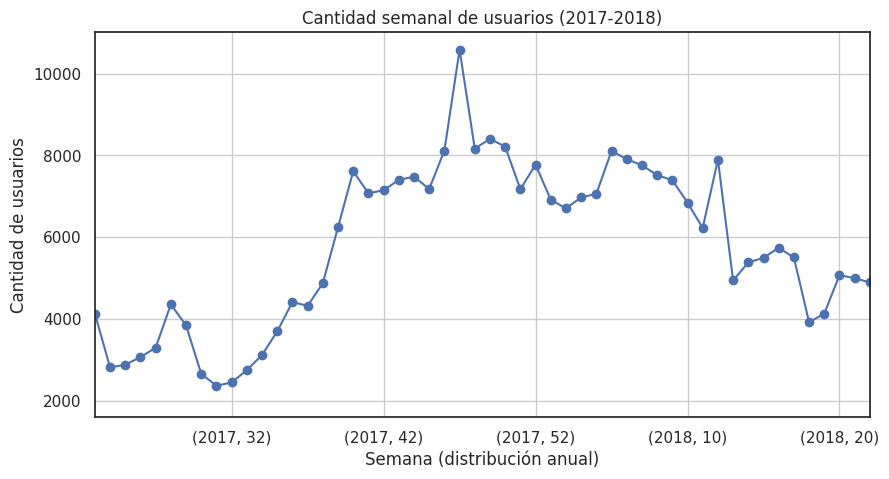

In [21]:
weekly_nusers = visits.groupby(['session_year','session_week']).agg({'uid': 'nunique'})
weekly_nusers.plot(grid='on', legend=False, figsize=(10,5), style='o-', title='Cantidad semanal de usuarios (2017-2018)', xlabel='Semana (distribución anual)', ylabel='Cantidad de usuarios', xlim=[1,52]);

De este gráfico se puede concluir que __en los mejores meses las visitas semanales oscilan entre 6.000 y 8.000, mientras que, en los meses malos, esta cifra fluctúa entre 2.000 y 4.000__. En la semana 47 de 2017 los visitantes superan los 10.000 a la semana, el valor más alto registrado. Finalmente, pasamos al gráfico diario.

,session_year,session_month,session_day,uid
176,2017,11,24,3319


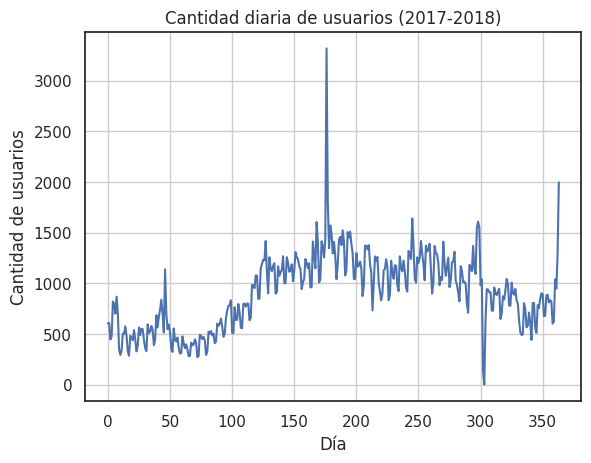

In [22]:
daily_nusers_ = visits.groupby(['session_year', 'session_month', 'session_day']).agg({'uid': 'nunique'}).reset_index()
daily_nusers_.plot(y='uid', grid='on', legend=False, ylabel='Cantidad de usuarios', xlabel='Día', title='Cantidad diaria de usuarios (2017-2018)');
daily_nusers_[daily_nusers_['uid'] == 3319]

Este gráfico muestra que __el número de visitas diarias tiende a oscilar entre 1.000 y 1.500 en días buenos, y en temporada baja fluctúa alrededor de los 500 visitantes diarios__, hay días excepcionales donde se han registrado 2.000 y 3.000 visitas diarias, seguramente debido a una oferta muy buena, o una viralización de una campaña de marketing.

__El día con más visitas registrado es el 24 de noviembre con 3.319 visitas__, debido a la fecha seguramente la causa sea una oferta navideña y/o las fechas de pago de los clientes que desean hacer sus compras navideñas.

#### ¿Cuántas sesiones hay por día? 

Para responder esta pregunta se hará un análisis descriptivo para complementar el análisis diario anterior.

               uid
count   364.000000
mean    987.362637
std     418.994796
min       1.000000
25%     635.500000
50%    1003.000000
75%    1280.000000
max    4042.000000


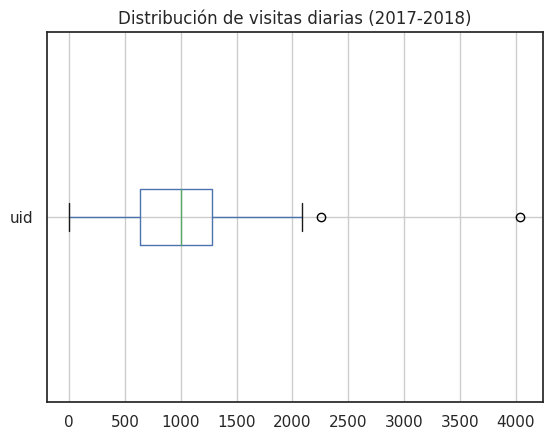

In [23]:
sessions_per_day = visits.groupby(['session_month', 'session_day']).agg({'uid': 'count'})
print(sessions_per_day.describe())
sessions_per_day.plot(kind='box', vert=False, grid='on', title='Distribución de visitas diarias (2017-2018)');

__Se observa una media de 987 sesiones por día__, los registros muestran que normalmente esta cifra fluctúa entre 635 y 1280.

#### ¿Cuál es la duración de cada sesión?

Para responder esta pregunta se se calculará la duración de cada visita restando la fecha de inicio a la fecha de término de cada visita, este cálculo se almacenará en la columna `session_duration_sec`.

Duración promedio de una visita: 643.51 segundos


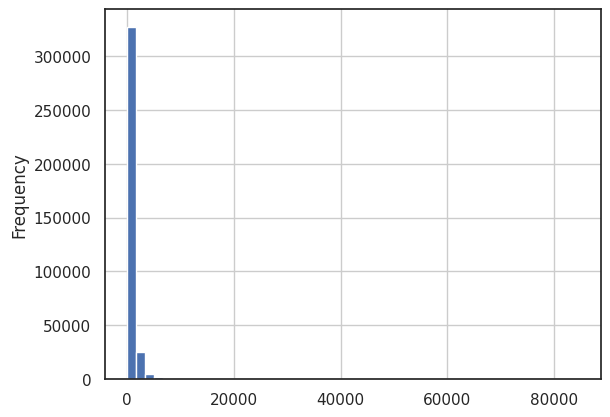

In [24]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
print('Duración promedio de una visita:' ,visits['session_duration_sec'].mean().round(2), 'segundos')
visits['session_duration_sec'].plot(kind='hist', grid='on', bins=50);

La media del tiempo de duración de cada visita es de 643 segundos, sin embargo, __esto sólo es válido si la distribución es normal o casi normal y el histograma demuestra que es el caso contrario, por ende se deberá calcular la moda__.

In [25]:
print(visits['session_duration_sec'].mode())

0    60
dtype: int64


__Tenemos como resultado un ASL de 60 segundos__, esto puede deberse a alguna característica de la página web, ya sea en la versión de pc o en la móvil, entre otros posibles motivos.

#### ¿Con qué frecuencia los usuarios y las usuarias regresan?

Para responder esta pregunta se calculará la tasa de retención mensual (%) de los usuarios de la web, se hará una división por cohortes, lo cual es útil para graficar los cambios de esta métrica en el tiempo (si es que hubieran). El primer paso es extraer la fecha de la primera visita a la web de cada usuario.

In [26]:
first_session_dt = visits.groupby('uid').agg({'start_ts': 'min'}).reset_index()
first_session_dt.columns = ['uid', 'first_session_dt']
first_session_dt.head(5)

,uid,first_session_dt
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


Mediante esta agrupación se consigue un dataframe con los id de usuario y la fecha de su primera visita al sitio web. Con este nuevo dataset se puede calcular la diferencia de tiempo entre cada visita y la primera visita a la web del usuario.

In [27]:
retention = visits.merge(first_session_dt, on='uid', how='left')
retention['first_session_month'] = retention['first_session_dt'].astype('datetime64[M]')
retention['session_month'] = retention['start_ts'].astype('datetime64[M]')
retention['cohort_lifetime'] = retention['session_month'] - retention['first_session_month']
retention['cohort_lifetime'] = retention['cohort_lifetime'] / np.timedelta64(1, 'M')
retention['cohort_lifetime'] = retention['cohort_lifetime'].round().astype('int')
retention.head(5)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_day,session_duration_sec,first_session_dt,first_session_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,20,1080,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,19,1680,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,1,0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,20,1440,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,27,0,2017-12-27 14:06:00,2017-12-01,0


Se crea un dataframe que contiene la información de las visitas y la fecha de la primera visita por id de usuario, se le añada la columna `cohort_lifetime` que indica  __la diferencia, en meses, de tiempo entre cada visita y la primera visita a la web del usuario__. Ahora queda obtener el número de clientes que permanecen visitando la web después de x meses.

In [28]:
cohorts = retention.groupby(['first_session_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
cohorts.head(5)

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Mediante la agrupación se obtiene el número de usuarios según el mes de su visita respecto de su primera visita. Ahora, se extraerá la cohorte 0 ya que sobre esta se harán los calculos para el porcentaje de retención del resto de las cohortes.

In [29]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month', 'uid']]
initial_users_count.columns = ['first_session_month', 'cohort_users']
initial_users_count.head(5)

,first_session_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


En este filtrado se extrae la cohorte 0, la cantidad total de visitantes sobre la cual se calculará la tasa de retención.

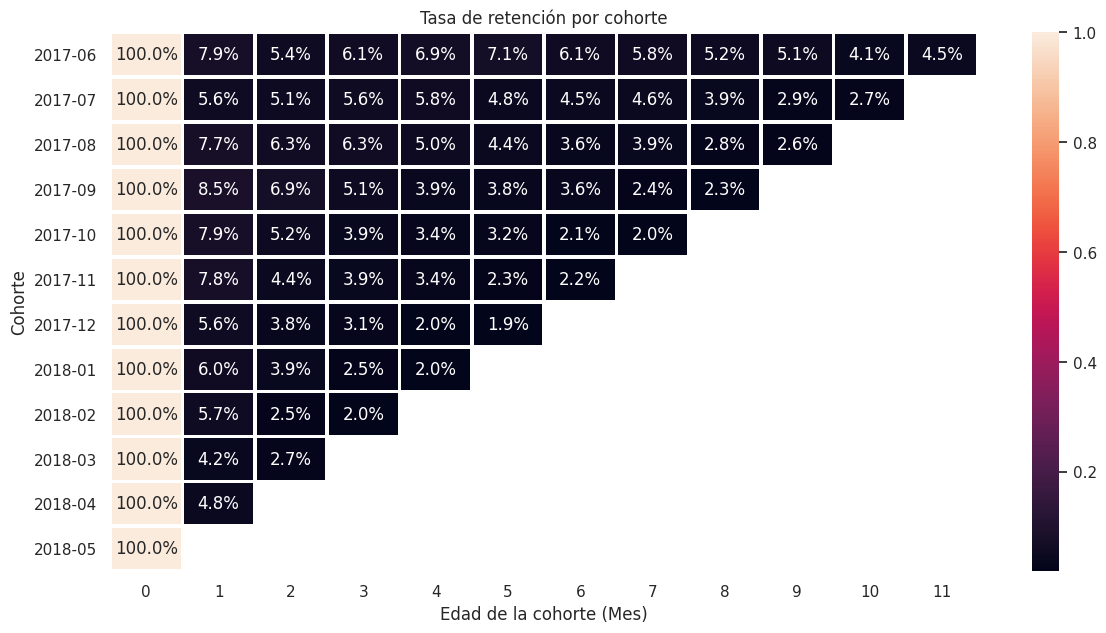

In [30]:
cohorts = cohorts.merge(initial_users_count, on='first_session_month')
cohorts['retention'] =  cohorts['uid'] /  cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_session_month', columns='cohort_lifetime', values='retention', aggfunc='sum')
plt.figure(figsize=(14, 7))
plt.title('Tasa de retención por cohorte')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=2, linecolor='white').set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.xlabel('Edad de la cohorte (Mes)')
plt.ylabel('Cohorte');

Finalmente, mediante una división, se calcula el porcentaje de retención por cohorte y se visualiza mediante un mapa de calor.

Viendo el gráfico se puede apreciar que __la retención ha ido bajando desde la cohorte de `2017-12`, la cohorte con mejor tasa de retención es la de `2017-06`__, podría deberse a algún cambio en la estrategia de marketing o a cambios en el flujo de visitas, se seguirá investigando.

### Ventas

La segunda sección del análisis tratará sobre todo lo relacionado a las visitas del sitio web de la compañía.

#### ¿Cuándo la gente empieza a comprar?

Para responder esta pregunta se calculará cuantos días desde la primera visita a la web se tardan los clientes en hacer la primera compra. Empezamos obteniendo la fecha de la primera compra de cada cliente.

In [31]:
first_order_dates = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_order_dates.columns = ['uid', 'first_order_date']
first_order_dates.head(5)

,uid,first_order_date
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


Mediante esta agrupación se obtiene un dataframe con los id de usuario y la fecha de su primera compra. Ahora debemos combinarlo con la información de la primera visita a la web.

In [32]:
time_to_convertion = first_order_dates.merge(first_session_dt, on='uid', how='left')
time_to_convertion.head(5)

,uid,first_order_date,first_session_dt
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Combinamos mediante un `merge` la agrupación anterior y el dataframe `first_session_dt`, obteniendo una nueva tabla con fechas de primera visita y primera compra por id de usuario. Por último, sacamos la diferencia entre la primera visita y la primera compra y la mostramos en días, para visualizar los datos de hasta 7 días después del día de la primera visita a la web.

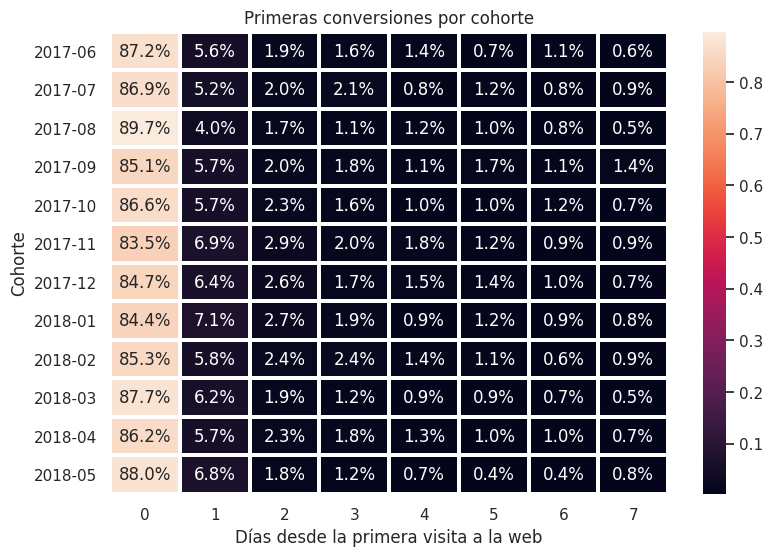

In [33]:
time_to_convertion['time_to_convertion'] =  time_to_convertion['first_order_date'] - time_to_convertion['first_session_dt']
time_to_convertion['days_to_convertion'] = time_to_convertion['time_to_convertion'] / np.timedelta64(1, 'D')
time_to_convertion['days_to_convertion'] = time_to_convertion['days_to_convertion'].round().astype('int')
time_to_convertion['first_session_month'] = time_to_convertion['first_session_dt'].astype('datetime64[M]')

week_filter = time_to_convertion[time_to_convertion['days_to_convertion'] <= 7]
pivot = week_filter.pivot_table(index='first_session_month', columns='days_to_convertion', values='uid', aggfunc='count')

row_totals = pivot.sum(axis=1)
pivot_percentage = pivot.div(row_totals, axis=0)

plt.figure(figsize=(9, 6))
plt.title('Primeras conversiones por cohorte')
sns.heatmap(pivot_percentage, annot=True, fmt='.1%', linewidths=2, linecolor='white').set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.ylabel('Cohorte')
plt.xlabel('Días desde la primera visita a la web');

Después de agregar a la tabla los días de diferencia entre la primera visita y la primera compra, y de organizarlo mediante una tabla dinámica y, posteriormente, un mapa de calor, se puede sacar la siguiente conclusión: __La gran mayoría de las compras se realiza el mismo dia que la primera visita al sitio web__. Se investigará como funcionan las ventas durante la primera hora desde la visita a la web.

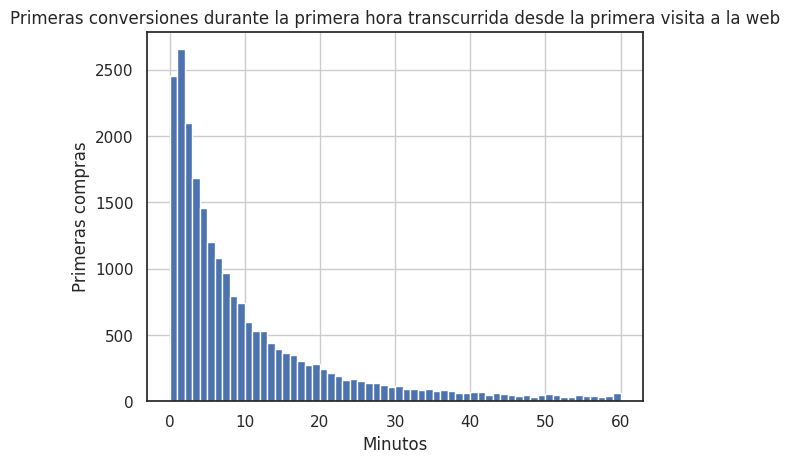

In [34]:
time_to_convertion['minutes_to_convertion'] = time_to_convertion['time_to_convertion'] / np.timedelta64(1, 'm')
time_to_convertion['minutes_to_convertion'] = time_to_convertion['minutes_to_convertion'].round().astype('int')
time_to_convertion['minutes_to_convertion'].plot(kind='hist', bins=60, grid='on', range=(0, 60), title='Primeras conversiones durante la primera hora transcurrida desde la primera visita a la web')
plt.xlabel('Minutos')
plt.ylabel('Primeras compras');

Del presente histograma se puede concluir que __una gran mayoría hace la primera compra en los primeros 5 minutos desde la primera visita a la web, y el peak está en los dos minutos, esto prueba que el ASL de 60 segundos (de momento) no es perjudicial para las ventas__, ya que es tiempo necesario para hacer una compra en el sitio web.

#### ¿Cuántos pedidos hacen durante un período de tiempo dado?

Se indagará cuantos pedidos se hacen mensualmente y de estos pedidos cuantos son de clientes nuevos o antiguos, se explorarán también las preferencias por dispositivos. Se comienza graficando los pedidos totales por mes.

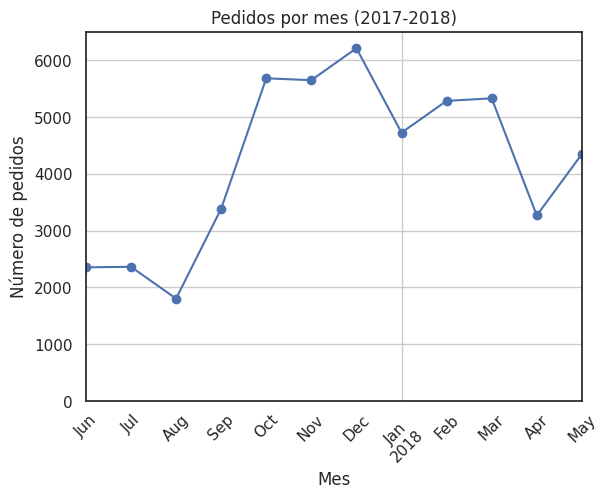

In [35]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
time_plot = orders.groupby('order_month').agg({'uid': 'count'})
time_plot.plot(style='o-', grid='on', legend=False, rot=45, ylabel='Número de pedidos', title='Pedidos por mes (2017-2018)', xlim=['2017-06-01', '2018-05-01'], ylim=[0,6500], xlabel='Mes');

__Mediante este gráfico se puede apreciar que el peor mes en ventas fue agosto de 2017, y los mejores fueron: octubre, noviembre y diciembre (debido a navidad, probablemente)__, también, se puede observar que, __a pesar de las caídas, las ventas parecen ir aumentando con el tiempo__. Se seguirá investigando mediante un análisis de cohortes.

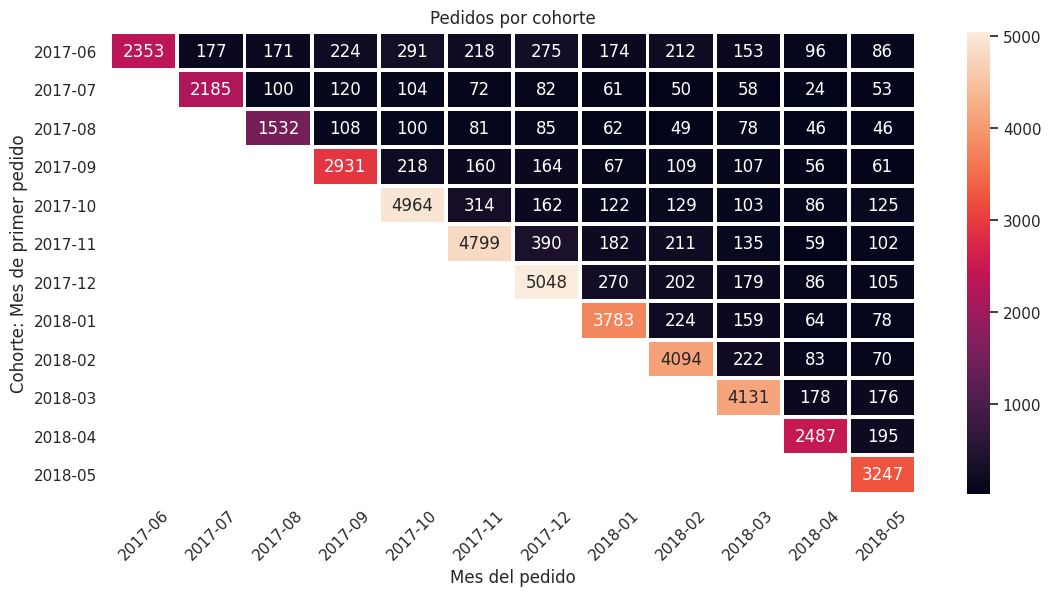

In [36]:
time = orders.merge(first_order_dates, on='uid', how='left') # Combinar info
time['first_order_month'] = time['first_order_date'].astype('datetime64[M]')
time['order_month'] = time['buy_ts'].astype('datetime64[M]').dt.strftime('%Y-%m')
time_fm = time[time['order_month'] != '2018-06']
time_pivot = time_fm.pivot_table(index='first_order_month', columns='order_month', values='uid', aggfunc='count')

plt.figure(figsize=(13, 6)) #Graficar
plt.title('Pedidos por cohorte')
plt.xticks(rotation=45)
sns.heatmap(time_pivot, annot=True, fmt='.0f', linewidths=2, linecolor='white').set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.xlabel('Mes del pedido')
plt.ylabel('Cohorte: Mes de primer pedido');

Añadiendo un dataframe con las primeras fechas de compra de los clientes a `orders` obtenemos `time`, mediante una tabla dinámica podemos generar un análisis de cohortes mensuales graficable mediante un mapa de calor.

Del siguiente mapa de calor se puede concluir que __los tres mejores meses en compras a clientes nuevos son octubre, noviembre y diciembre, y el peor, agosto__. También podemos apreciar que __la cohorte de junio de 2017 sobresale en cuanto a retención de compras__.

Ahora se analizará la cantidad de pedidos por fuente de anuncios.

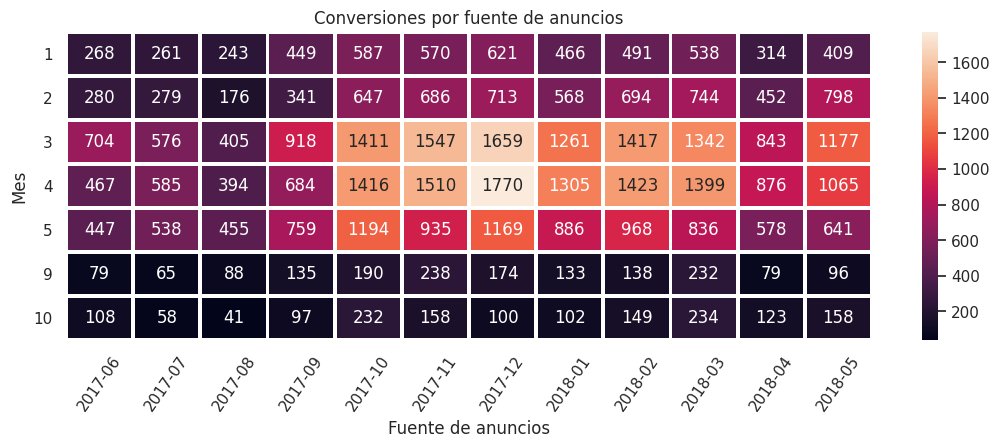

In [37]:
first_session_id = visits.groupby(['uid', 'source_id']).agg({'start_ts': 'min'}).reset_index() #Aislar el id y la fecha de la primera visita
first_session_id.columns = ['uid', 'source_id', 'first_session_dt']
first_session_id = first_session_id.sort_values(by='first_session_dt')
first_session_id = first_session_id.drop_duplicates('uid', keep='first') 

id_convertions = orders.merge(first_session_id, on='uid', how='left') #Combinar la información en un solo dataframe
id_convertions['order_month'] = id_convertions['buy_ts'].astype('datetime64[M]')
id_convertions = id_convertions[id_convertions['order_month'] != '2018-06-01']
id_convertions = id_convertions[id_convertions['source_id'] != 7]
id_convertions['order_month'] = id_convertions['order_month'].dt.strftime('%Y-%m')

id_pivot = id_convertions.pivot_table(index='source_id', columns='order_month', values='uid', aggfunc='count') #Generar cohortes
plt.figure(figsize=(13, 4)) #Graficar
plt.title('Conversiones por fuente de anuncios')
sns.heatmap(id_pivot, annot=True, fmt='.0f', linewidths=2, linecolor='white')
plt.xticks(rotation=55)
plt.yticks(rotation=0)
plt.xlabel('Fuente de anuncios')
plt.ylabel('Mes');

En `first_session_id` aislamos la fecha de la primera visita y la fuente del anuncio que la condujo (por id de usuario), sumando esta información al dataset `orders`, podemos generar el presente mapa de calor.

Observando el gráfico, podemos destacar las fuentes: 3, 4 y 5, __esta información aún no es concluyente, ya que, por el momento, no se sabe cuánto se invirtió en cada campaña y el tamaño de las compras realizadas__.

Se procede a realizar un análisis por dispositivo de primera visita.

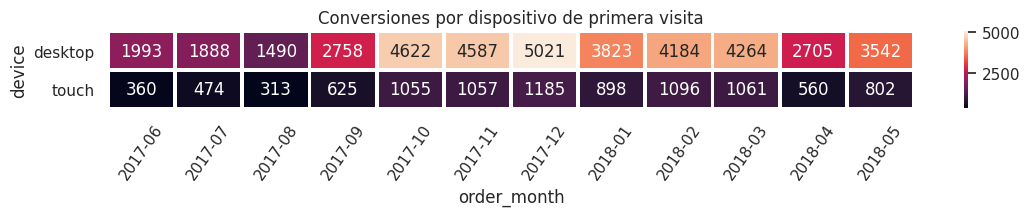

In [38]:
first_session_dv = visits.groupby(['uid', 'device']).agg({'start_ts': 'min'}).reset_index() #Agrupar info
first_session_dv.columns = ['uid', 'device', 'first_session_dt']
first_session_dv = first_session_dv.sort_values(by='first_session_dt')
first_session_dv = first_session_dv.drop_duplicates('uid', keep='first')

dv_convertions = orders.merge(first_session_dv, on='uid', how='left') #Combinar info
dv_convertions['order_month'] = dv_convertions['buy_ts'].astype('datetime64[M]')
dv_convertions = dv_convertions[dv_convertions['order_month'] != '2018-06-01']
dv_convertions['order_month'] = dv_convertions['order_month'].dt.strftime('%Y-%m')

dv_pivot = dv_convertions.pivot_table(index='device', columns='order_month', values='uid', aggfunc='count') #Visualizar info
plt.figure(figsize=(13, 1))
plt.title('Conversiones por dispositivo de primera visita')
sns.heatmap(dv_pivot, annot=True, fmt='.0f', linewidths=2, linecolor='white')
plt.xticks(rotation=55)
plt.yticks(rotation=0);

Mediante un procedimiento parecido al del gráfico anterior, podemos obtener el dispositivo en el que se visitó la web por primera vez. Se observa claramente que __los clientes de esta web prefieren entrar desde un pc antes que un dispositivo touch__.

#### ¿Cuál es el tamaño promedio de compra?

Para responder esta pregunta se analizará descriptivamente la variable.

count    50364.000000
mean         5.004710
std         21.828823
min          0.010000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64



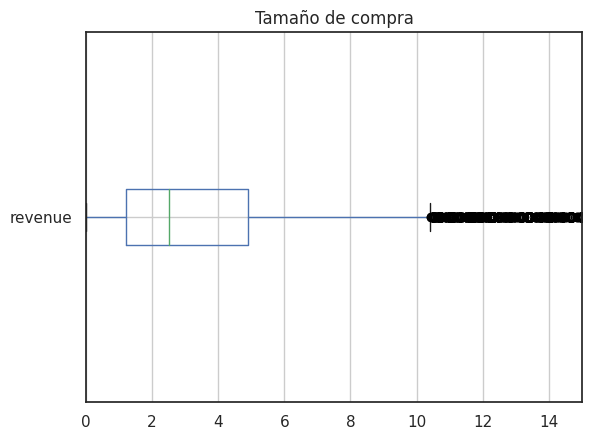

In [39]:
print(orders[orders['revenue'] != 0]['revenue'].describe())
print()
orders[orders['revenue'] != 0]['revenue'].plot(kind='box', vert=False, xlim=[0,15], grid='on', title='Tamaño de compra');

__El tamaño de las compras suele fluctuar entre 1.22 y 4.89 dólares__, el que la media sea mayor a la mediana evidencia valores atípicos muy grandes, como también se confirma observando que la compra más cara que se ha hecho es de $2633. Para establecer una cifra podemos decir que __la mediana de tamaño de compra es de 2.5 dólares__.

#### ¿Cuánto dinero traen? (LTV)

Se procederá a calcular el LTV de los clientes de la compañía, es decir, la ganancia que un cliente genera para una empresa mientras mantiene relación con ella. El primer paso es obtener el mes de primera compra de cada cliente.

In [40]:
first_orders =  orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
first_orders.head(5)

,uid,first_order_month
0,313578113262317,2018-01-01
1,1575281904278712,2017-06-01
2,2429014661409475,2017-10-01
3,2464366381792757,2018-01-01
4,2551852515556206,2017-11-01


Mediante la agrupación `first_orders` se extrae el mes de la primera compra de cada cliente. Ahora se calcularán las ganancias por cliente de cada mes.

In [41]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index() #Agrupar info
cohort_sizes.columns = ['first_order_month', 'n_buyers']

orders_ = pd.merge(orders, first_orders, on='uid') # Combinar info
cohorts = orders_.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
report['order_month'] = report['order_month'].astype('datetime64[M]')
report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M') #Calcular nueva info
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']
report.head(5)

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2022,2017-06-01,9557.49,0,4.726751
1,2017-06-01,2022,2017-07-01,981.82,1,0.485569
2,2017-06-01,2022,2017-08-01,885.34,2,0.437854
3,2017-06-01,2022,2017-09-01,1931.30,3,0.955143
4,2017-06-01,2022,2017-10-01,2068.58,4,1.023037


Mediante los filtrados y agrupaciones, se obtiene el número de clientes y el ingreso por cohorte, luego se calcula `'age'` que es la diferencia en meses desde la primera compra hasta la compra actual. Finalmente se genera la columna `'ltv'` que es el aporte mensual de cada cliente. Finalmente se reorganiza la información en una tabla dinámica con suma horizontal en donde la última columna es la suma total registrada.

In [42]:
output_cumsum = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean').round(2)
output_cumsum = output_cumsum.cumsum(axis=1)
output_cumsum.fillna('', inplace=True)
output_cumsum[:12]

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.73,5.22,5.66,6.62,7.64,8.38,9.33,9.91,10.46,11.07,11.64,11.9
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09-01,5.65,6.77,7.29,11.27,11.67,12.32,13.02,13.26,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.16,5.56,5.76,6.09,6.24,6.29,6.41,,,,,
2017-12-01,4.74,5.0,5.93,7.0,7.31,7.65,,,,,,
2018-01-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02-01,4.16,4.44,4.52,4.59,,,,,,,,


A través de esta tabla dinámina acumulativa se puede ver el LTV de las diferentes cohortes, basta con observar el último valor de cada fila, por ejemplo: __el LTV de la cohorte `2017-06-01` es de 11.88 dólares__, lo que significa que si el costo de adquisición por cliente es menor, hay ganancia, si no, hay pérdida.

### Marketing

La tercera y última sección del análisis tratará sobre todo lo relacionado a las campañas de marketing de la compañía.

#### Clientes ganados por fuente de anuncios

Se trazará un gráfico de barras para graficar la cantidad de clientes y el tipo de dispositivo con el que llegaron la compañía, por fuente de anuncios. Para esto necesitamos información del dataset `visits` y la variable `first_order_dates` que se creó anteriormente.

In [43]:
first_session_mt = visits.groupby(['uid', 'device','source_id']).agg({'start_ts': 'min'}).reset_index() #Extraer fuente de anuncio y dispositivo
first_session_mt.columns = ['uid', 'device', 'source_id', 'first_session_dt']
first_session_mt = first_session_mt.sort_values(by='first_session_dt')
first_session_mt = first_session_mt.drop_duplicates('uid', keep='first')

mt_convertions = first_order_dates.merge(first_session_mt, on='uid', how='left') #Combinar info
mt_convertions = mt_convertions.groupby(['source_id', 'device']).agg({'uid': 'count'}).reset_index()
mt_convertions = mt_convertions[mt_convertions['source_id'] != 7]
mt_convertions = mt_convertions.reset_index().drop('index', axis=1)
mt_convertions.head(5)

,source_id,device,uid
0,1,desktop,2262
1,1,touch,634
2,2,desktop,2646
3,2,touch,857
4,3,desktop,8718


En `first_session_mt` se extrae el id de fuente y el dispositivo de la primera visita de cada cliente, al generar `mt_convertions` obtuvimos una lista de las primeras compras de cada cliente con el id de anuncio y el dispositivo de su primera visita a la web. Ahora solo queda construir la gráfica.

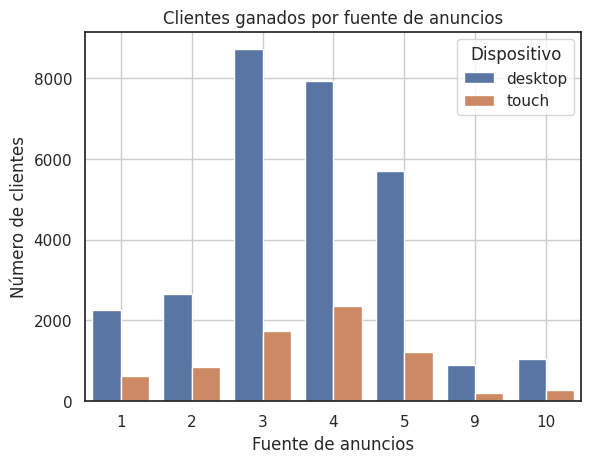

In [44]:
sns.barplot(data=mt_convertions, x='source_id', y='uid', hue='device').set_title('Clientes ganados por fuente de anuncios')
plt.grid(True)
plt.xlabel('Fuente de anuncios')
plt.ylabel('Número de clientes')
plt.legend(title='Dispositivo');

Este gráfico muestra que __las campañas 3, 4 y 5 fueron las que trajeron más clientes tanto por pc's como en dispositivos touch__.

#### Ratio de conversión por fuente de anuncios

Para obtener esta métrica necesitamos la variable `mt_convertions` creada anteriormente y el dataset `visits`.

In [45]:
vmt = visits.groupby(['source_id', 'device']).agg({'uid': 'nunique'}).reset_index() # Visitas agrupadas por cantidad de usuarios por id de anuncio y dispositivos
vmt = vmt.drop([10, 11, 12, 13], axis=0).reset_index().drop('index', axis=1)

ret = pd.concat([mt_convertions, vmt], axis='columns') #Combinar con compras agrupadas por cantidad de usuarios por id de anuncio y dispositivo
ret.columns = ['source_id','device', 'n_buyers', 'x', 'y', 'n_visitors']
ret = ret.drop(['x', 'y'], axis='columns')
ret['retention_rate_%'] = (ret['n_buyers'] / ret['n_visitors']) * 100 #Sacar porcentaje de conversion de usuarios
ret.head(5)

,source_id,device,n_buyers,n_visitors,retention_rate_%
0,1,desktop,2262,13172,17.172791
1,1,touch,634,6094,10.403676
2,2,desktop,2646,18257,14.493071
3,2,touch,857,8609,9.954699
4,3,desktop,8718,57420,15.182863


Se crea `ret`, que contiene información tanto de cantidad de visitantes como de compradores, por id de anuncio y dispositivo de la primera visita, al dividir la cantidad de compradores por la de visitantes obtenemos el porcentaje de retención de usuarios de cada fuente de anuncios y dispositivo. Ahora solo queda construir el gráfico.

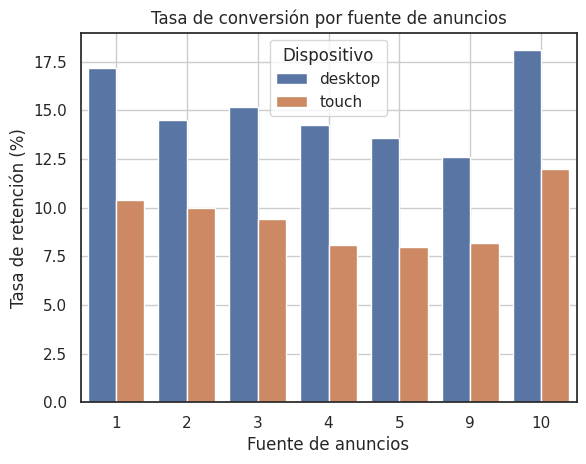

In [46]:
sns.barplot(data=ret, x='source_id', y='retention_rate_%', hue='device').set_title('Tasa de conversión por fuente de anuncios')
plt.ylabel('Tasa de retención (%)')
plt.xlabel('Fuente de anuncios')
plt.grid(True)
plt.legend(title='Dispositivo');

__La fuente 1 y la 10 muestran tener valores más altos que el resto de fuentes__, aunque esto por sí solo no es una prueba %100 concluyente, ya que los porcentajes de retención pueden variar de acuerdo al presupuesto invertido.

#### ¿Cuánto dinero se gastó? (Total/por fuente de adquisición/a lo largo del tiempo)

Para responder esta pregunta lo más conveniente es un gráfico de lineas para el desglose mensual y un gráfico de barras para ver los gastos totales durante el periodo estudiado. Empezaremos con el gráfico de líneas.

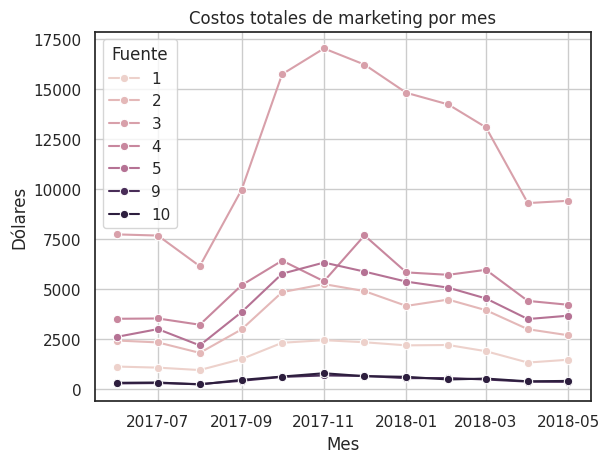

In [47]:
costs['month'] = costs['dt'].astype('datetime64[M]')
monthly_cost = costs.groupby(['month', 'source_id'])['costs'].sum().reset_index()
monthly_cost.head()
sns.lineplot(data=monthly_cost, x='month', y='costs', marker='o', hue='source_id').set_title('Costos totales de marketing por mes')
plt.grid(True)
plt.xlabel('Mes')
plt.ylabel('Dólares')
plt.legend([1, 2, 3, 4, 5, 9, 10], title='Fuente');

Esta gráfica indica que entre octubre de 2017 y marzo de 2018 __se gastó el doble en la fuente 3 de anuncios, respecto de las otras campañas__. Las campañas 2, 4 y 5 han tenido gastos similares, diferenciandose la  4 sólo en diciembre de 2017.

La campaña id 9 e id 10 tienen un gasto prácticamente idéntico y nulo, siendo visible el punto negro sólamente en noviembre.

Ahora se construirá el gráfico de barras.

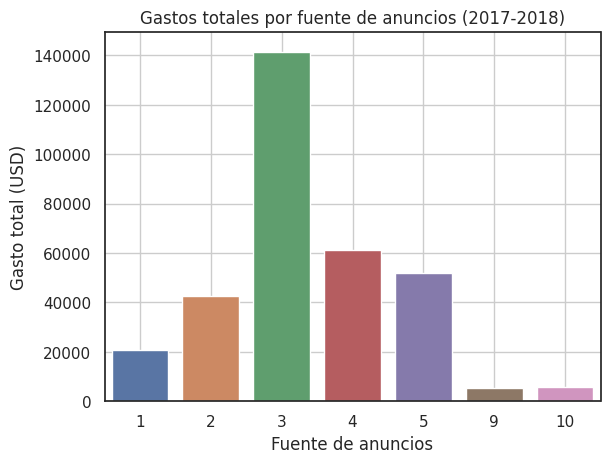

In [48]:
sns.barplot(data=monthly_cost, x='source_id', y='costs', estimator=sum, ci=False).set_title('Gastos totales por fuente de anuncios (2017-2018)')
plt.ylabel('Gasto total (USD)')
plt.xlabel('Fuente de anuncios')
plt.grid(True);

Este gráfico evidencia aun más __la diferencia de gastos en la campaña 3 respecto de las otras__.

#### ¿Cuál fue el costo de adquisición de clientes de cada una de las fuentes?

Para responder a esta pregunta se trazarán dos gráficos de barras, uno del CAC por fuente y otro del CAC por cohorte, para tener información de la calidad de los anuncios y de las diferencias causadas por la estacionalidad. Para ello debemos extraer el número de compradores traídos por cada fuente y dividir los gastos totales de cada `source_id` por este número.

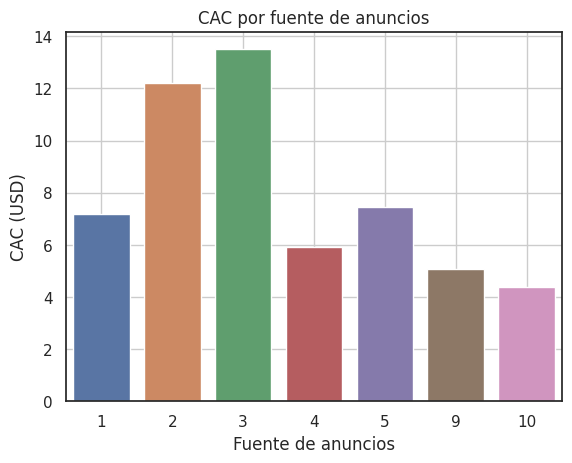

In [49]:
convertions = first_order_dates.merge(first_session_mt, on='uid', how='left')

n_buyers_1 = convertions[convertions['source_id'] == 1]['uid'].nunique() #Extraer la cantidad de clientes atraídos por cada fuente de anuncios
n_buyers_2 = convertions[convertions['source_id'] == 2]['uid'].nunique()
n_buyers_3 = convertions[convertions['source_id'] == 3]['uid'].nunique()
n_buyers_4 = convertions[convertions['source_id'] == 4]['uid'].nunique()
n_buyers_5 = convertions[convertions['source_id'] == 5]['uid'].nunique()
n_buyers_9 = convertions[convertions['source_id'] == 9]['uid'].nunique()
n_buyers_10 = convertions[convertions['source_id'] == 10]['uid'].nunique()

n_buyers = pd.Series([n_buyers_1, n_buyers_2, n_buyers_3, n_buyers_4, n_buyers_5, n_buyers_9, n_buyers_10]) # Compilar info en un Series

total_cost = monthly_cost.groupby('source_id')['costs'].sum().reset_index().drop('source_id', axis=1)
total_cost

cac_per_id = pd.concat([n_buyers, total_cost], axis=1) #Combinar info y visualizar
cac_per_id.columns = ['n_buyers', 'total_costs']
cac_per_id.index = [1, 2, 3, 4, 5, 9, 10]
cac_per_id['cac'] = cac_per_id['total_costs'] / cac_per_id['n_buyers']
cac_per_id = cac_per_id.reset_index()
sns.barplot(data=cac_per_id, x='index', y='cac').set_title('CAC por fuente de anuncios')
plt.grid(True)
plt.ylabel('CAC (USD)')
plt.xlabel('Fuente de anuncios');

Se obtiene la cantidad de clientes atraída por cada fuente de anuncios, se divide por los costos totales y nos da como resultado el CAC para cada fuente de anuncios.

__Las fuentes 2 y 3 muestran un costo muy elevado, mientras que le CAC de las fuentes 9 y 10 es la mitad de los mencionados anteriormente__.

Ahora pasaremos al análisis por cohorte.

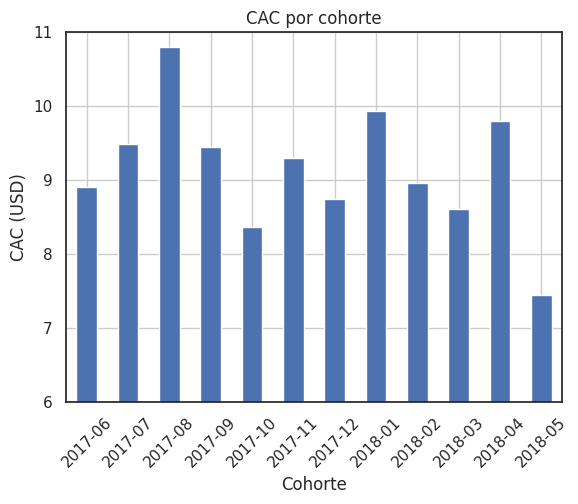

In [50]:
monthly_costs = costs.groupby('month').sum()
monthly_costs.drop('source_id', axis='columns')
report_ = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_['cac'] = report_['costs'] / report_['n_buyers']

report_plot = report_.groupby('first_order_month')['cac'].mean().reset_index()
report_plot['first_order_month'] = report_plot['first_order_month'].dt.strftime('%Y-%m')
report_plot.plot(x='first_order_month', y='cac', kind='bar', legend=False, grid='on', title='CAC por cohorte', ylabel='CAC (USD)', xlabel='Cohorte', rot=45, ylim=[6, 11]);

Mediante la agrupación de dos datasets obtenemos `report_` y se puede obtener `'cac'` dividiendo los gastos totales del período por la cantidad de usuarios.

__Se puede apreciar que el CAC mas alto está en agosto, enero y abril, que es cuando se dan bajas en las ventas totales__, esto puede deberse a que es más difícil conseguir clientes en estos meses, lo que hace que el costo de adquisición suba.

#### ¿Cuán rentables eran las inversiones? (ROMI)

Para calcular el ROMI por cada fuente se construirá un bucle for, para iterar sobre las fuentes con la fórmula.

In [51]:
monthly_costs_grouped = costs.groupby(['source_id', 'month']).agg({'costs': 'sum'}).reset_index()

# Lista de source_ids que deseas procesar
source_ids = monthly_costs_grouped['source_id'].unique()

# Crear un diccionario para almacenar los resultados de cada source_id
romi_results = {}

for source_id in source_ids:
    # Filtrar por fuente de anuncios en id_convertions y en monthly_costs_grouped
    idX_convertions = id_convertions[id_convertions['source_id'] == source_id]
    monthly_costs = monthly_costs_grouped[monthly_costs_grouped['source_id'] == source_id]
    
    # Calcular la primera orden por usuario
    first_orders = idX_convertions.groupby('uid').agg({'order_month': 'min'}).reset_index()
    first_orders.columns = ['uid', 'first_order_month']
    
    # Calcular el tamaño de cada cohorte
    cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
    
    # Combinar pedidos con la información de la primera orden
    orders_ = pd.merge(orders, first_orders, on='uid')
    cohorts = orders_.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()
    
    # Crear el reporte básico
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
    report['order_month'] = report['order_month'].astype('datetime64[M]')
    report['first_order_month'] = report['first_order_month'].astype('datetime64[M]')
    
    # Calcular la edad de la cohorte y el LTV
    report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
    report['ltv'] = report['revenue'] / report['n_buyers']
    
    # Introducir los costos mensuales de la fuente de anuncios correspondiente
    report_ = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
    report_['cac'] = report_['costs'] / report_['n_buyers']
    report_['romi'] = report_['ltv'] / report_['cac']
    
    # Visualizar ROMI acumulado
    romi = report_.pivot_table(index='first_order_month', values='romi', columns='age', aggfunc='mean')
    romi = romi.cumsum(axis=1).round(2)
    
    # Almacenar el resultado en el diccionario
    romi_results[source_id] = romi

El bucle está construído, por lo cual solo queda visualizar el ROMI de cada fuente de anuncios, para visualizar esta métrica se generarán mapas de calor.

##### Fuente 1

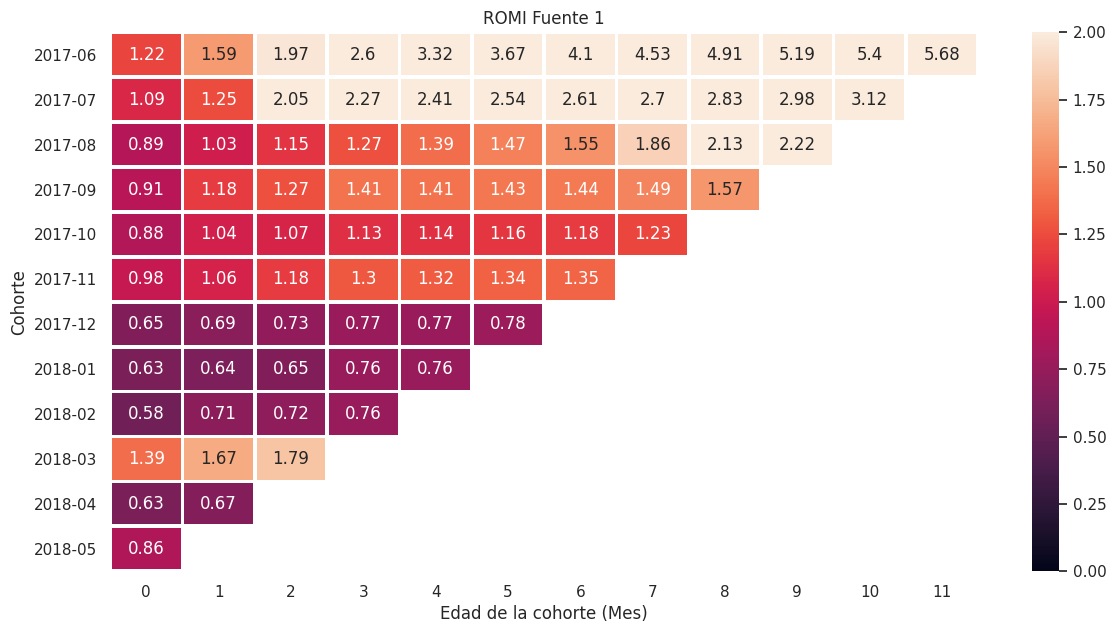

In [52]:
romi_results[1]
plt.figure(figsize=(14, 7))
sns.heatmap(romi_results[1], annot=True, fmt='', linewidths=2, linecolor='white', vmin=0, vmax=2).set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.title('ROMI Fuente 1')
plt.ylabel('Cohorte')
plt.xlabel('Edad de la cohorte (Mes)');

El ROMI de esta fuente se ve positivo, __los clientes empiezan a generar ganancias en el primer o segundo mes__ a excepción de los meses post navidad.

##### Fuente 2

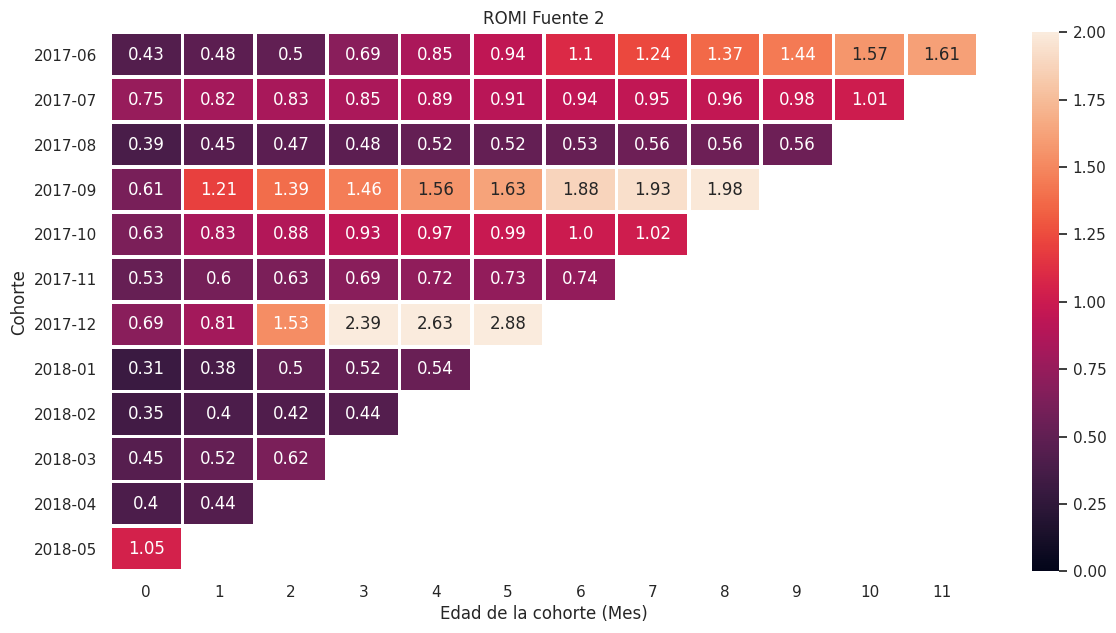

In [53]:
plt.figure(figsize=(14, 7))
sns.heatmap(romi_results[2], annot=True, fmt='', linewidths=2, linecolor='white', vmin=0, vmax=2).set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.title('ROMI Fuente 2')
plt.ylabel('Cohorte')
plt.xlabel('Edad de la cohorte (Mes)');

El ROMI de esta fuente no se ve tan fructífero, sin embargo, __hay cohortes donde tiene buena rentabilidad, como en la de mayo, diciembre y septiembre__. 

##### Fuente 3

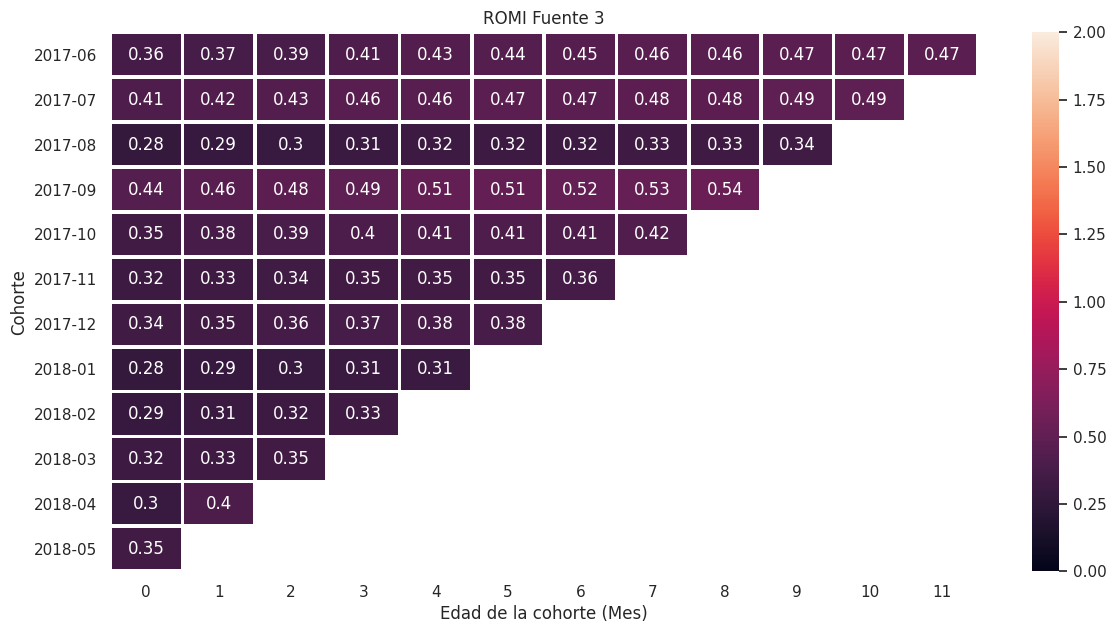

In [54]:
plt.figure(figsize=(14, 7))
sns.heatmap(romi_results[3], annot=True, fmt='', linewidths=2, linecolor='white', vmin=0, vmax=2).set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.title('ROMI Fuente 3')
plt.ylabel('Cohorte')
plt.xlabel('Edad de la cohorte (Mes)');

__El ROMI de esta fuente es evidentemente malo__, lo máximo que logra es recuperar la mitad de la inversión.

##### Fuente 4

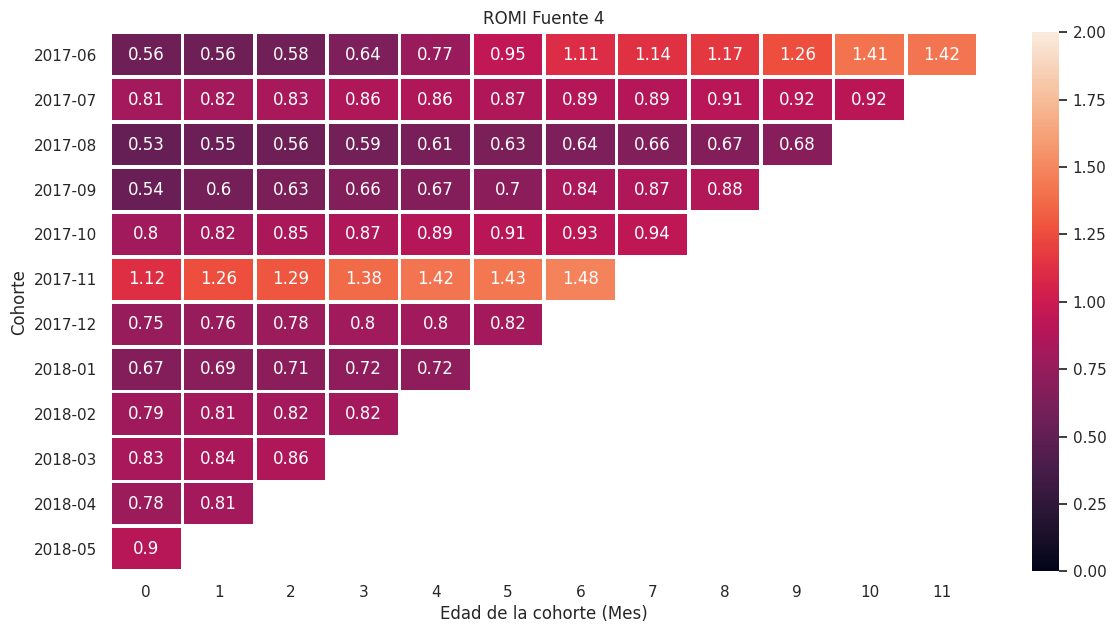

In [55]:
plt.figure(figsize=(14, 7))
sns.heatmap(romi_results[4], annot=True, fmt='', linewidths=2, linecolor='white', vmin=0, vmax=2).set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.title('ROMI Fuente 4')
plt.ylabel('Cohorte')
plt.xlabel('Edad de la cohorte (Mes)');

__El ROMI de esta fuente parecer ser bueno sólo en la cohorte de noviembre__, lo cual es útil ya que funciona bien como campaña para navidad.

##### Fuente 5

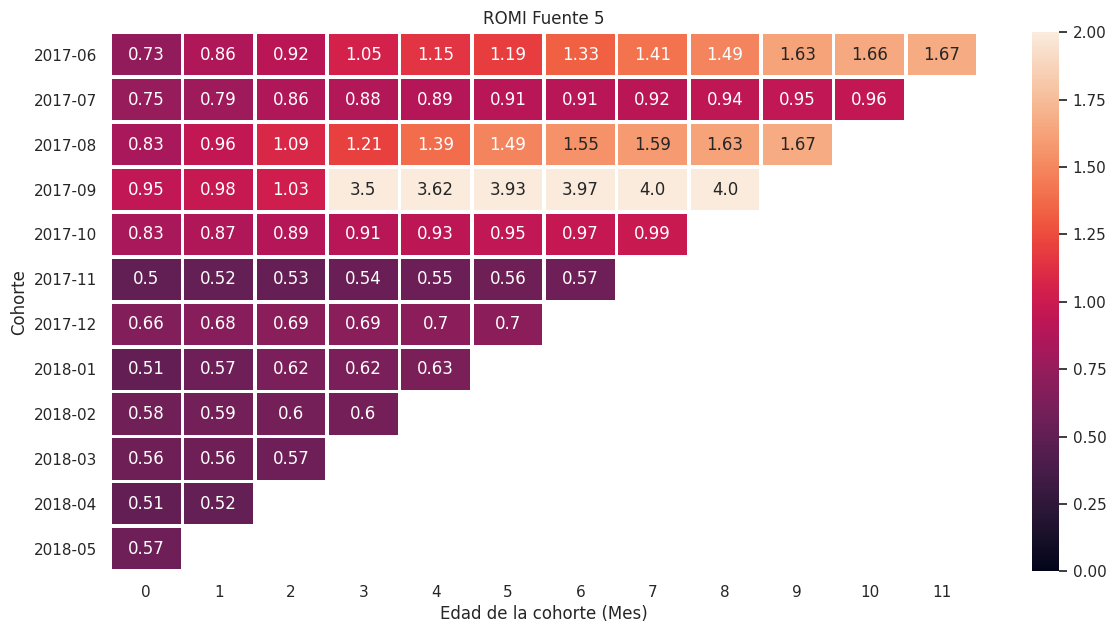

In [56]:
plt.figure(figsize=(14, 7))
sns.heatmap(romi_results[5], annot=True, fmt='', linewidths=2, linecolor='white', vmin=0, vmax=2).set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.title('ROMI Fuente 5')
plt.ylabel('Cohorte')
plt.xlabel('Edad de la cohorte (Mes)');

El ROMI de  esta fuente parece ser excepcionalmente bueno en la cohorte de septiembre, se puede observar que __dichos usuarios generan el doble de la inversión sólo en navidad__. El resto del año el rendimiento no es bueno.

##### Fuente 9

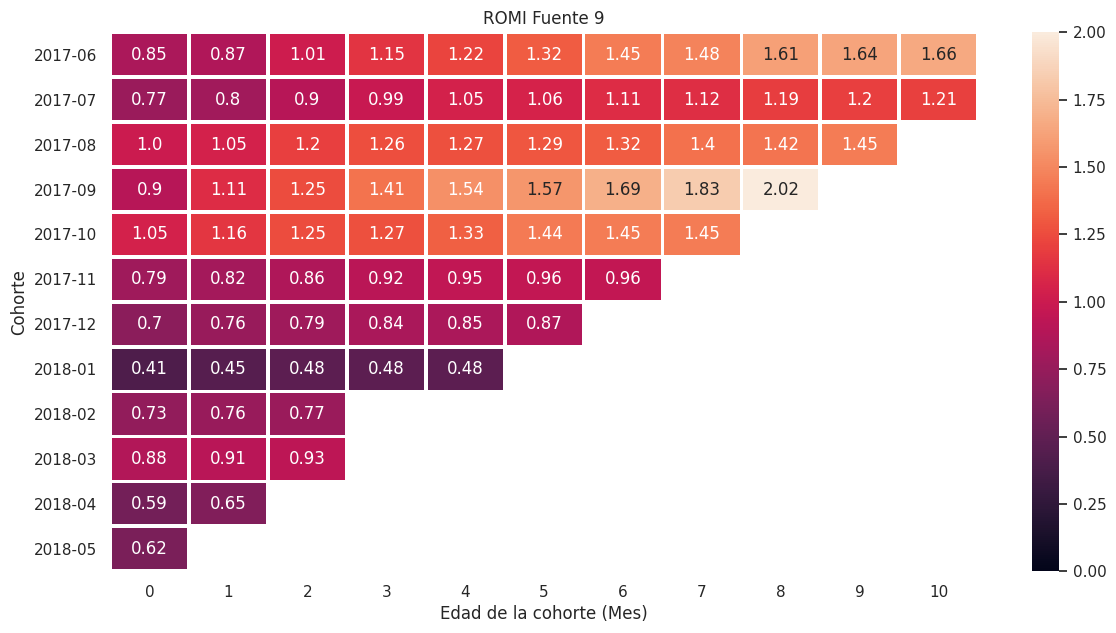

In [57]:
plt.figure(figsize=(14, 7))
sns.heatmap(romi_results[9], annot=True, fmt='', linewidths=2, linecolor='white', vmin=0, vmax=2).set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.title('ROMI Fuente 9')
plt.ylabel('Cohorte')
plt.xlabel('Edad de la cohorte (Mes)');

Esta fuente de anuncios tiene un rendimiento parecido a la fuente 1, pero con resultados un poco más bajos.

##### Fuente 10

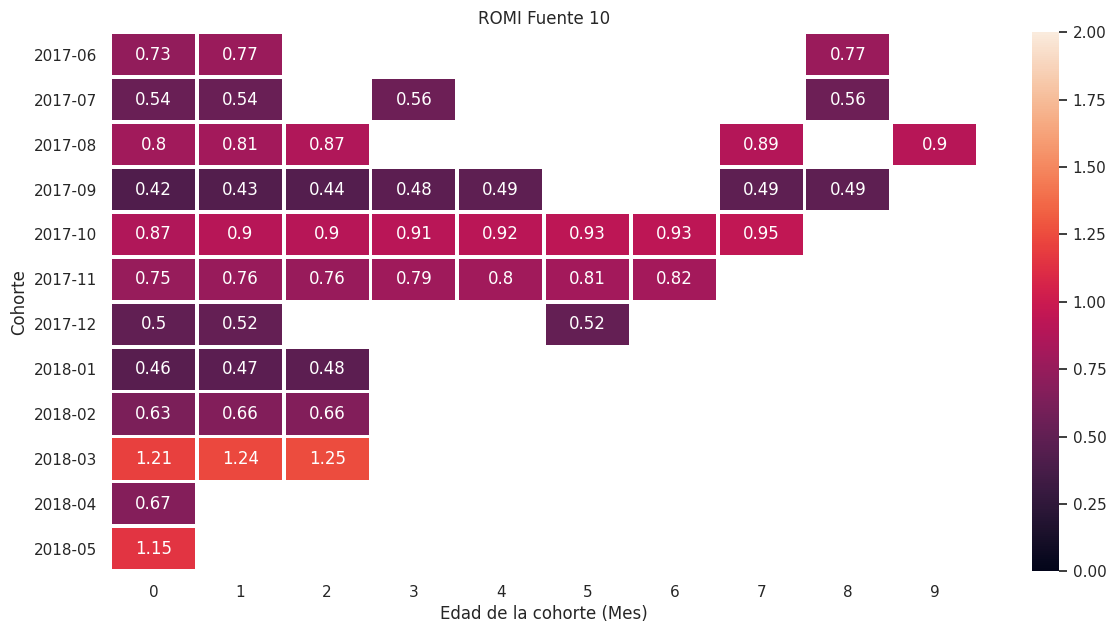

In [58]:
plt.figure(figsize=(14, 7))
sns.heatmap(romi_results[10], annot=True, fmt='', linewidths=2, linecolor='white', vmin=0, vmax=2).set_yticklabels(retention_pivot.index.strftime('%Y-%m'))
plt.title('ROMI Fuente 10')
plt.ylabel('Cohorte')
plt.xlabel('Edad de la cohorte (Mes)');

Los espacios en blanco significan que los usuarios atraídos por esta fuente no realizan muchas compras a través de los meses, sino que tienden a comprar una sola vez.

## Conclusiones

En este apartado se desarollarán ampliamente todas las conclusiones obtenidas en el desarrollo del informe, haciendo hincapié en los aspectos fundamentales del trabajo, como lo son: las visitas al sitio web, las ventas del negocio, las métricas clave de marketing y recomendaciones de inversión en publicidad.

### Visitas

- La tasa de retención es muy baja, ninguna cohorte supera el 10% de retención mensual, lo anterior indica que se deben tomar medidas para retener a los visitantes y a los clientes que hacen su primera compra.
- El ASL es de 60 segundos, lo cual es suficiente para que un cliente haga una compra.
- En promedio, cada visitante entra 1.08 veces al día a la web, lo cual también es suficiente para hacer una compra.

### Ventas

- Una gran mayoría de clientes hace su compra el mismo día de la primera visita a la web, y en específico durante los primeros 5 minutos.
- La mediana en cuanto a tamaño de ventas es 2.5 dólares y en general las compras son por valores bajos, hay un numero pequeño de compras muy grandes (por sobre los mil dolares) pero estas no afectan significativamente las metricas finales como el ROMI y el LTV.
- Los meses de octubre, noviembre y diciembre (navidad) son los mejores en cuanto a ventas y captación de nuevos clientes.
- el LTV de un cliente captado en junio de 2017 (la cohorte más antigua) es de 11.88 dólares.


### Marketing

- Los gastos de la fuente 3 de anuncios doblan a los de cualquier otra fuente.
- El CAC tiende a subir en los peores meses, lo que indica que es probable que por el rubro de la tienda, estos sean simplemente malos meses para la venta de estos productos.
- El Costo de adquisición de cliente de la fuente 3 es de más de 13 dólares, lo que nos da un indicio de lo poco rentable que está resultando esta fuente de anuncios.

### Recomendaciones de inversión

Después del análisis exhaustivo realizado en los datos proporcionados, se pueden desprender las siguientes recomendaciones de inversión, para optimizar el gasto destinado a marketing digital.

- Se recomienda __eliminar la fuente de anuncios 3 debido a que tiene CAC muy alto y no es capaz de generar ganancias sino al contrario, están generando pérdidas para la empresa__, en la cual se gastaron 140.000 dólares durante el año estudiado
- __La fuente 1 funciona bien__, genera ganancias la mayoría del año, salvo unos pocos meses (de diciembre a febrero y abril).
- La fuente 2 trae buenos resultados sólo en __septiembre y diciembre__.
- La fuente 4 trae buenos resultados sólo en __noviembre__.
- __La fuente 5 funciona bien para atraer compradores para navidad en el mes de septiembre, el resultado muestra que los clientes atraídos en esta fecha generaron muy buenos resultados__, sin embargo el resto del año la campaña no funciona bien.
- La fuente 9 trae resultados relativamente buenos __desde junio hasta octubre__.
- La fuente 10 ha mostrado buenos números en __marzo y mayo__.

A continuación se mostrará una visualización de las sugerencias.

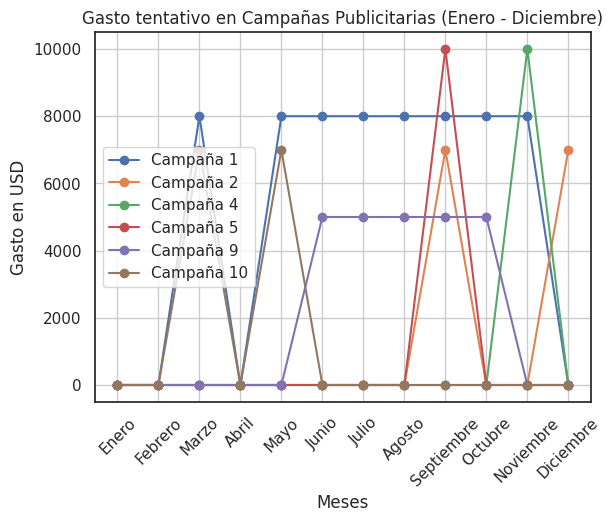

In [59]:
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
gastos_campaña_1 = [0, 0, 8000, 0, 8000, 8000, 8000, 8000, 8000, 8000, 8000, 0]
gastos_campaña_2 = [0, 0, 0, 0, 0, 0, 0, 0, 7000, 0, 0, 7000]
gastos_campaña_4 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10000, 0]
gastos_campaña_5 = [0, 0, 0, 0, 0, 0, 0, 0, 10000, 0, 0, 0]
gastos_campaña_9 = [0, 0, 0, 0, 0, 5000, 5000, 5000, 5000, 5000, 0, 0]
gastos_campaña_10 = [0, 0, 7000, 0, 7000, 0, 0, 0, 0, 0, 0, 0]

# Graficar los datos
plt.plot(meses, gastos_campaña_1, marker='o', label='Campaña 1')
plt.plot(meses, gastos_campaña_2, marker='o', label='Campaña 2')
plt.plot(meses, gastos_campaña_4, marker='o', label='Campaña 4')
plt.plot(meses, gastos_campaña_5, marker='o', label='Campaña 5')
plt.plot(meses, gastos_campaña_9, marker='o', label='Campaña 9')
plt.plot(meses, gastos_campaña_10, marker='o', label='Campaña 10')

# Añadir títulos y etiquetas
plt.title('Gasto tentativo en Campañas Publicitarias (Enero - Diciembre)')
plt.xlabel('Meses')
plt.ylabel('Gasto en USD')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend();

Este gráfico solo es un esqueleto para ilustrar de manera visual las sugerencias del punto anterior.